In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
import tensorflow_probability as tfp
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import tensorflow as tf
from scipy import stats
tfd=tfp.distributions
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tqdm import notebook
from sklearn.model_selection import KFold


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

### Simulate Data

In [3]:
np.random.seed(2020)

# generate x1-x4, gaussian
mu=np.random.normal(scale=2,size=1000)

# generate x5, uniform
sig=np.random.uniform(0.5,2.5,size=1000)


# the full design matrix
x=np.c_[mu,sig]


y=np.random.normal(loc=mu,scale=sig,size=(1000,1))


train_x=x[:700,:]
train_y=y[:700,:]

test_x=x[700:,:]
test_y=y[700:,:]


Code refer to {https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net}

###  MC-Dropout(DP)

#### normalization function

In [4]:
##define a normalization function
def norm_data(train, test,norm=True):
    std_train=np.ones(train.shape[1])
    mu_train=np.zeros(train.shape[1])
    if(norm):
        std_train = np.std(train, 0)
        mu_train=np.mean(train,0)

    train=(train - np.full(train.shape, mu_train)) / \
            np.full(train.shape, std_train)
    test=(test - np.full(test.shape, mu_train)) / \
            np.full(test.shape, std_train)
    return train,test,mu_train,std_train

In [5]:
train_x,test_x,_,_=norm_data(train_x,test_x,norm=False)
train_y,_,muy,stdy=norm_data(train_y,test_y,norm=False)

### define model

In [6]:
class MCdp:
    def __init__(self,tau,dropout):
        self.tau=tau
        self.dropout=dropout

    #use normal approximation for output, by drawing 1000 samples
    def model_musd(self,trainx,trainy,testx):    
        # construct the network
        N = len(trainx)
        batch_size = 128
        lengthscale = 1e-2
        reg = lengthscale**2 * (1 - self.dropout) / (2. * N * self.tau)
        inputs = Input(shape=(train_x.shape[1],))
        inter = Dropout(self.dropout)(inputs, training=True)
        inter = Dense(100, activation='relu',kernel_regularizer=l2(reg))(inputs)
        inter = Dropout(self.dropout)(inter, training=True)
        inter = Dense(50, activation='relu',kernel_regularizer=l2(reg))(inter)
        inter = Dropout(self.dropout)(inter, training=True)
        outputs = Dense(1,kernel_regularizer=l2(reg))(inter)
        model= Model(inputs,outputs)
        opt = keras.optimizers.Adam()
        model.compile(loss='mean_squared_error', optimizer=opt)
        model.fit(train_x, train_y, batch_size=batch_size, epochs=300, verbose=0)

        #generate 1000 posterior samples
        ntest=len(testx)
        Yt_hat=np.zeros((1000,ntest))
        for t in notebook.tnrange(1000):
            mu=model.predict(testx, batch_size=128,verbose=0).ravel() 
            Yt_hat[t,:] = mu
        MC_pred=np.mean(Yt_hat, 0)

        MC_std=np.sqrt(np.diag((Yt_hat.T@Yt_hat)/1000)-MC_pred**2+1./self.tau)
        return MC_pred, MC_std



#### 5-fold cross validation for parameter tuning

In [8]:
tauval=[0.25,0.5,0.75]
dpval=[0.01,0.05,0.1]
hyperparam=np.zeros((9,2))
hyperparam[:,0]=np.repeat(tauval,3)
hyperparam[:,1]=np.tile(dpval,3)

In [9]:
## create 5 folds
id = np.arange(len(train_x))
kf = KFold(n_splits=5)
tuneresult=[]


for i in range(len(hyperparam)):
    
    ## tuning parameter
    tautmp=hyperparam[i,0]
    dptmp=hyperparam[i,1]

    for trainid, testid in kf.split(id):
        mcdptmp=MCdp(tautmp,dptmp)
        mutmp,stdtmp=mcdptmp.model_musd(train_x[trainid],train_y[trainid],train_x[testid])

        ## extract validation y
        testytmp=train_y[testid]
           
        ##likelihood
        low=np.quantile(testytmp,0.05)
        high=np.quantile(testytmp,0.95)
        itv=np.linspace(low,high,9)
        itv=np.append(-np.infty,itv)
        itv=np.append(itv,np.infty)
        #outcome1 belongs to which interval
        ids=np.zeros(len(testytmp))
        for i in range(10):
            ids=ids+1*(testytmp.ravel()>itv[i+1])
        ids=ids.astype('int')
        

        l=(itv[ids]-mutmp)/stdtmp
        r=(itv[ids+1]-mutmp)/stdtmp
        prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
        ll_est=np.log(prtmp+1.e-10)
        
        tuneresult.append(ll_est.mean())            



In [16]:
list(zip([np.mean(tuneresult[i*5:(i+1)*5]) for i in range(9)],hyperparam))

[(-1.8357259587066406, array([0.25, 0.01])),
 (-1.8367169607528488, array([0.25, 0.05])),
 (-1.8389105689195702, array([0.25, 0.1 ])),
 (-1.7872219042646893, array([0.5 , 0.01])),
 (-1.7894991621227478, array([0.5 , 0.05])),
 (-1.789773471554857, array([0.5, 0.1])),
 (-1.8601474937931797, array([0.75, 0.01])),
 (-1.8595276424660514, array([0.75, 0.05])),
 (-1.8577774899836381, array([0.75, 0.1 ]))]

### We choose tau=0.5,dp=0.01 ad the best tunning parameter for model fitting

In [7]:
mcdptuned=MCdp(0.5,0.01)

dpmu,dpstd=mcdptuned.model_musd(train_x,train_y,test_x)


## evaluation

### median by MAE

In [18]:
np.abs((dpmu*stdy+muy)-test_y.ravel()).mean()

1.156771039554111

### calibration

In [8]:
per=np.linspace(0.02,0.98,8)

In [9]:
#generate confidence interval through sampling to approximate asymptotic distribution
dpc=[]
dpwidth=stats.norm.ppf(0.95)*2*stdy*dpstd

per=np.linspace(0.02,0.98,8)
for i in per:
    lquantile=(stats.norm.ppf(0.5-i/2.)*dpstd+dpmu)*stdy+muy
    rquantile=(stats.norm.ppf(0.5+i/2.)*dpstd+dpmu)*stdy+muy
    dpc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

l90=(stats.norm.ppf(0.5-0.9/2.)*dpstd+dpmu)*stdy+muy
r90=(stats.norm.ppf(0.5+0.9/2.)*dpstd+dpmu)*stdy+muy
np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel()))    

0.8733333333333333

In [21]:
dpc,np.abs(dpc-per).mean()

([0.006666666666666667,
  0.19666666666666666,
  0.3466666666666667,
  0.49666666666666665,
  0.6033333333333334,
  0.7066666666666667,
  0.8366666666666667,
  0.9533333333333334],
 0.029880952380952373)

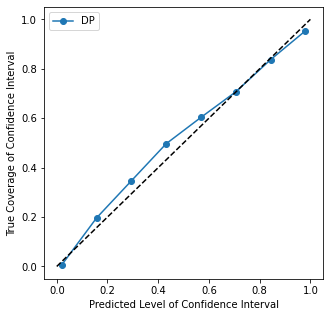

In [22]:
plt.plot(per,dpc,'o-',label='DP')
plt.xlabel('Predicted Level of Confidence Interval')
plt.ylabel('True Coverage of Confidence Interval')
plt.legend()
plt.plot([0,1],[0,1],'k--')
fig = plt.gcf()
fig.set_size_inches(5,5)

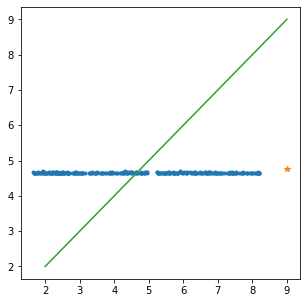

In [13]:
## 90% interval width
plt.figure(figsize=(5,5))
plt.plot(sig[700:].ravel()*2.*1.64,dpwidth,'.')
plt.plot(9,2*stats.norm.ppf(0.95)*sig[700:].mean(),'*')
plt.plot([2,9],[2,9])

In [ ]:
np.save('dpwidth',dpwidth)

### log likelihood


In [25]:
##likelihood
low=np.quantile(test_y,0.05)
high=np.quantile(test_y,0.95)
itv=np.linspace(low,high,9)
itv=np.append(-np.infty,itv)
itv=np.append(itv,np.infty)
#outcome1 belongs to which interval
id=np.zeros(len(test_y))
for i in range(10):
    id=id+1*(test_y.ravel()>itv[i+1])
id=id.astype('int')

In [26]:

l=((itv[id]-muy)/stdy-dpmu)/dpstd
r=((itv[id+1]-muy)/stdy-dpmu)/dpstd
prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
ll_est=np.log(prtmp+1.e-10)
ll_est.mean()

-1.8107179798976702

#### Compare the generated distribution to groud truth for three random samples

In [27]:
#generate sample
np.random.seed(2020)
samps=np.random.choice(len(test_x),3)

In [28]:
samps

array([118, 195,  91])

In [29]:
#the mean and sd for the random sample
musd=x[700:][samps]

In [30]:
musd

array([[ 1.67091651,  1.66674477],
       [-1.34299445,  1.77077775],
       [-1.40733603,  2.09394208]])

In [31]:
yrange=np.linspace(musd[:,0]-4*musd[:,1],musd[:,0]+4*musd[:,1],5000)

In [32]:
## mean and sd for dp sample
dpmusd=np.c_[dpmu,dpstd][samps]
dpmusd

array([[ 1.48584941,  1.41554226],
       [-0.95897809,  1.41560427],
       [-1.04133316,  1.41608509]])

In [33]:
dpyrange=(yrange-muy)/stdy

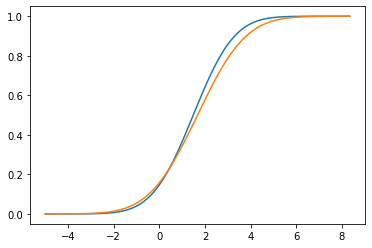

In [34]:
tcdf=stats.norm.cdf((yrange[:,0]-musd[0,0])/musd[0,1])
dpcdf=stats.norm.cdf((dpyrange[:,0]-dpmusd[0,0])/dpmusd[0,1])

plt.plot(yrange[:,0],dpcdf)
plt.plot(yrange[:,0],tcdf)


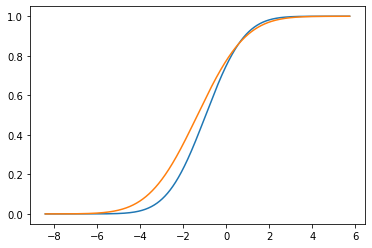

In [35]:
tcdf=stats.norm.cdf((yrange[:,1]-musd[1,0])/musd[1,1])
dpcdf=stats.norm.cdf((dpyrange[:,1]-dpmusd[1,0])/dpmusd[1,1])

plt.plot(yrange[:,1],dpcdf)
plt.plot(yrange[:,1],tcdf)


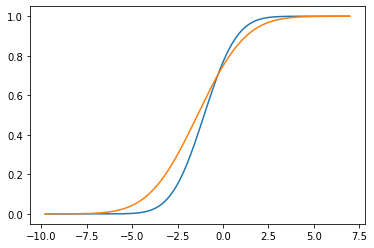

In [36]:
tcdf=stats.norm.cdf((yrange[:,2]-musd[2,0])/musd[2,1])
dpcdf=stats.norm.cdf((dpyrange[:,2]-dpmusd[2,0])/dpmusd[2,1])

plt.plot(yrange[:,2],dpcdf)
plt.plot(yrange[:,2],tcdf)